# 01 Image Classification with fastai

## 1. The fastai Philosophy

In [1]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:90% !important; }</style>"))

- [fastai](https://www.fast.ai/) is a software package and course created by Jeremy Howard, Rachel Thomas, and Sylvain Gugger. 
- A good way to think about fastai is as a high level PyTorch wrapper library. If you're familiar with keras, **tensorflow is to keras and pytorch is (roughly) to fastai.**
- Unlike keras, fastai is **very opinionated** library. 
- Instead of creating a generic tools for deep learning experts to use, the fastai founders are creating courses and a library that make it **dramatically easier and faster** to get cutting-edge results quickly with deep learning. 
- One tool they use to accomplish this is by **encoding best practices from research directly into the library**. 
- This approach has led to some pretty dramatic results, including [training a model on imagenet in 18 minutes](https://www.fast.ai/2018/08/10/fastai-diu-imagenet/) and some breakthrough results in [pretraining models for natural language processing](https://arxiv.org/pdf/1801.06146.pdf). 
- Now, there are some trade-offs. In my experience, fastai can be buggy, difficult to debug, and challenging to generalize in some cases. 
- My thinking on these trade-offs, in 2020, is this: 


1. For quickly exploring + testing top-performing models and new ideas on your own datasets, **it's hard to beat fastai**. In my experience, you'll be able to test lots of ideas quickly, and move fast. 
2. Having a reasonable good understanding of the underlying PyTorch code can make you much more effective with fastai, allowing you to "pick and choose" the parts of the fastai library you want to use, and what you want to implement yourself in PyTorch. 
3. I still really like Keras and Tensorflow, but I rarely use these libraries as **starting points** on new projects. 

---

## 2. Let's Get Some Data

In [1]:
!pip install wget #For colab

ERROR: Invalid requirement: '#For'


In [2]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9686 sha256=b3253aeac35eea86e570e606687b111e638cc13fc81129ead7fa700b0e1511f6
  Stored in directory: c:\users\janihenr\appdata\local\pip\cache\wheels\a1\b6\7c\0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [3]:
import wget, argparse, zipfile, tarfile, sys
from pathlib import Path

def simple_progress_bar(current, total, width=80):
    progress_message = "Downloading: %d%% [%d / %d] bytes" % (current / total * 100, current, total)
    sys.stdout.write("\r" + progress_message); sys.stdout.flush()

def get_and_unpack(url, location='data/'):
    Path(location).mkdir(exist_ok=True)
    filename = wget.download(url, out=location, bar=simple_progress_bar)
    zip_ref = zipfile.ZipFile(filename, 'r')
    zip_ref.extractall(path=location)
    zip_ref.close()

In [4]:
get_and_unpack(url='http://www.welchlabs.io/unccv/deep_learning/bbc_train.zip')

Downloading: 100% [90591239 / 90591239] bytes

**Optional in Workshop - let's code this part together from scratch in an empty notebook.**

In [6]:
%pylab inline
from fastai.vision import *
from pathlib import Path
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [5]:
path=Path('data/bbc_train')

In [7]:
path.ls()

[WindowsPath('data/bbc_train/.DS_Store'),
 WindowsPath('data/bbc_train/bboxes.json'),
 WindowsPath('data/bbc_train/classification_labels.csv'),
 WindowsPath('data/bbc_train/images'),
 WindowsPath('data/bbc_train/masks')]

- The BBC-1k dataset inlcudes labels for classification, bounding box detection, and semantic segmentation. 
- Let's load the classification labels:

In [11]:
labels=pd.read_csv(path/'classification_labels.csv')

In [14]:
labels.head(20)

,filename,label,label_index
0,P2050936.jpg,ball,2
1,P2050922.jpg,ball,2
2,P2060163.jpg,brick,1
3,P2060003.jpg,ball,2
4,P2060017.jpg,ball,2
5,P2060016.jpg,ball,2
6,P2060002.jpg,ball,2
7,P2060162.jpg,brick,1
8,P2050923.jpg,ball,2
9,P2050937.jpg,ball,2


- fastai provides lots of methods for creating data iterators, called `DataBunches` in the fastai nomenclature
- `DataBunches` allow us to quickly create pipelines for loading data into randomized minibatches

In [15]:
len(labels)

942

## 3. Setup fastai ImageDataBunch

In [25]:
data=ImageDataBunch.from_df(path=path/'images', df=labels, valid_pct=0.2, fn_col='filename', label_col='label', 
                            ds_tfms=get_transforms(), size=256, bs=64).normalize(imagenet_stats)
# valid_pct: float = 0.2, --> almost force you to have a validation data set --> 20% is validation data of all
# get_transforms -> automatically rotates, zooms, mirros, etc augments the image
# size is image size, 256 is relatively high
# bs = batch size -> better estimate, more hungry, in practise not a huge factor, there are other things that take more time
# normalize -> huge OS image net standard normalization, scaling with this data, it can help

In [24]:
# check that images are there
(path/'images').ls()[:5]

[WindowsPath('data/bbc_train/images/.DS_Store'),
 WindowsPath('data/bbc_train/images/P2050200.jpg'),
 WindowsPath('data/bbc_train/images/P2050201.jpg'),
 WindowsPath('data/bbc_train/images/P2050202.jpg'),
 WindowsPath('data/bbc_train/images/P2050203.jpg')]

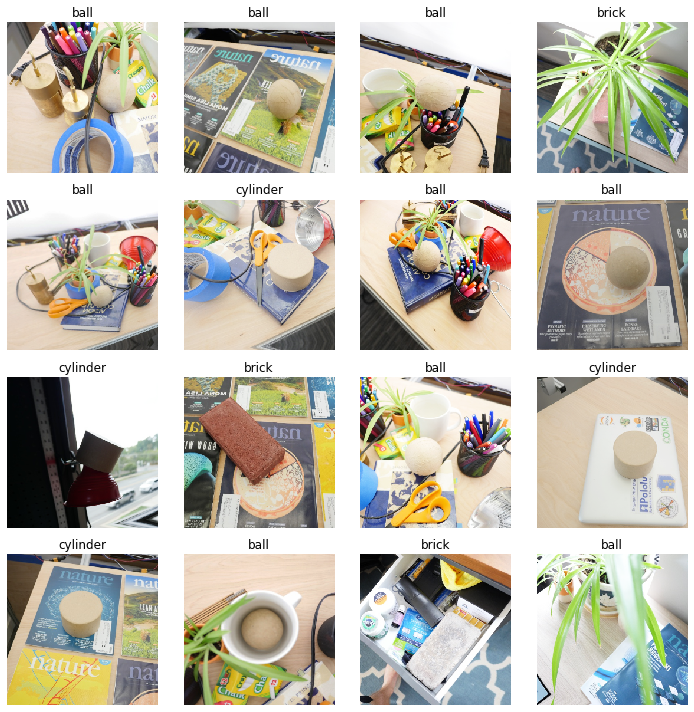

In [27]:
data.show_batch(4, figsize=(10,10))

- Creating a model is as simple as picking an architecture, passing in our `ImageDataBunch`, and choosing a performance metric!

## 4. Create Learner, Find Learning Rate

In [30]:
# learner holds the model and data - fastai makes things more convenient
learn=cnn_learner(data, models.resnet34, metrics=accuracy)
# models. -> gives available models
# 5 resnet models -> nr corresponds to the number of layers, better perf but may overfit and takes longer
# good idea to test

# downloads the weights

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to C:\Users\janihenr/.cache\torch\checkpoints\resnet34-333f7ec4.pth


In [29]:
# check the architecture -> relu cuts the linearity, really important part
# best book by far is is good fellow deep learning
models.resnet34()
# last row -> Linear(in_features=512, out_features=1000, bias=True) -> 1000 classes

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

- By default, fastai downloads the weights for a pretrained model. 
- Usually when solving new problems, it's best to start with a pretrained model, and just train the last few layers on the new task. 
- We can do this by freezing the "model backbone": 

In [31]:
learn.model # check our model
# last row -> out_features=3 --> our case

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [13]:
# generally good idea to use pretrained -> uses resnet

learn.freeze()
# freezes the rest of the model except the head -> 
# why: 1) faster, 2) small dataset, less likely to overfit, 3) 

- Choosing a learning rate can be difficult. 
- fastai provides a great tool for selecting an effective learning rate, `learn.lr_find()`.
- `lr_find` takes steps using various learning rates, and measure the change in our loss function. 
- By plotting the loss as a function of learning rate, we can select an ideal learning rate. 
- Ideally, we want to pick a learning that maximizes the slope of our loss vs learning rate curve. 

In [32]:
learn.lr_find()
# nice trick, a lot of hyperparameters, this checks those through, use GPU if possible because it is 
# finding 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


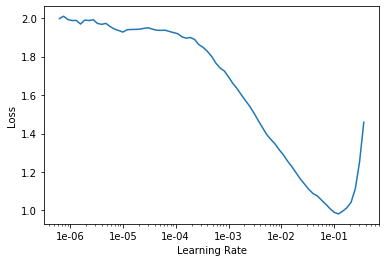

In [33]:
learn.recorder.plot()

- Fastai has a couple of other terrific built in features, **cylical learning rates**, and **differential learning rates**. 
- We're using each of these here, and will cover them in more detail later. 

## 5. Train Model

In [34]:
lr=5e-3
learn.fit_one_cycle(4, slice(lr/10, lr))

epoch,train_loss,valid_loss,accuracy,time
0,1.142836,0.930534,0.728723,05:54
1,0.724936,0.134451,0.952128,06:22
2,0.502337,0.082496,0.973404,06:47
3,0.388380,0.074281,0.968085,07:04


In [ ]:
# validation down and back up --> sign of overfit, should be worried

- We can further improve performance by training the whole model, not just our last few layers. 

In [17]:
learn.unfreeze()

In [18]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


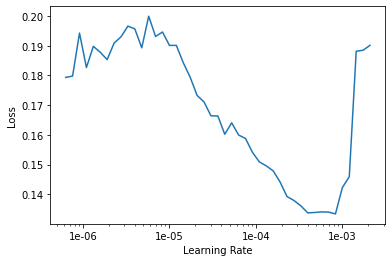

In [19]:
learn.recorder.plot()

In [20]:
lr=5e-5
learn.fit_one_cycle(8, slice(lr/10, lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.190439,0.083184,0.968085,00:05
1,0.168292,0.070853,0.973404,00:05
2,0.143626,0.044429,0.984043,00:05
3,0.130008,0.034518,0.989362,00:05
4,0.111329,0.041401,0.978723,00:05
5,0.098933,0.042582,0.984043,00:05
6,0.086356,0.041824,0.984043,00:05
7,0.080190,0.040751,0.984043,00:05


## 6. Visualize Results

- fastai also has some really nice visualization & interpretation methods:

In [35]:
interp=ClassificationInterpretation.from_learner(learn)

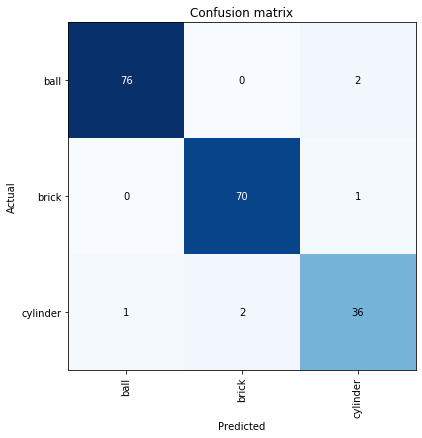

In [36]:
interp.plot_confusion_matrix(figsize=(6,6))

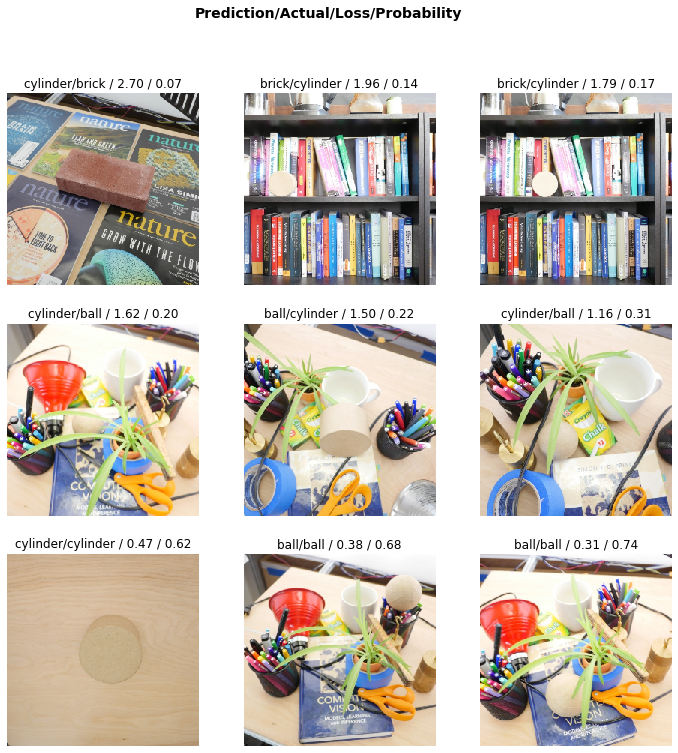

In [38]:
interp.plot_top_losses(k=9, figsize=(12, 12))

## 7. Save Model Weights

In [47]:
path.ls()

[WindowsPath('data/bbc_train/.DS_Store'),
 WindowsPath('data/bbc_train/bboxes.json'),
 WindowsPath('data/bbc_train/classification_labels.csv'),
 WindowsPath('data/bbc_train/images'),
 WindowsPath('data/bbc_train/masks'),
 WindowsPath('data/bbc_train/models')]

In [53]:
# C:\Users\janihenr\Documents\GitHub\dsgo-dl-workshop-summer-2020-master\data
learn.export(r'C:\Users\janihenr\Documents\GitHub\dsgo-dl-workshop-summer-2020-master\data\bbc-classifier.pkl')
#learn.export(path,'bbc-classifier.pkl') #Save Weights Locally

- If running from google colab, you can download the model weights by clicking the file icon on the left.
- You can also save directly to your google drive - cool right?!
- This will come in handy for model deploymnet later
- You may need to create a folder called "dsgo" in you google drive for the export link below to work
- Also, note that to automatically download your model file, you may need to create a share-able link in google drive, and change the file permissions to allow anyone with the link to view.

In [55]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 128, 128]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 128, 128]       128        True      
______________________________________________________________________
ReLU                 [64, 128, 128]       0          False     
______________________________________________________________________
MaxPool2d            [64, 64, 64]         0          False     
______________________________________________________________________
Conv2d               [64, 64, 64]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        True      
______________________________________________________________________
ReLU                 [64, 64, 64]         0          False     
___________________________________________________

In [56]:
import google.colab

ModuleNotFoundError: No module named 'google.colab'

In [43]:
from google.colab import drive
drive.mount('/content/gdrive')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
learn.export('/content/gdrive/My Drive/dsgo/bbc-classifier.pkl')